In [1]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
from patsy import dmatrices
import statsmodels.api as sm

In [2]:
## Todo: Make new 'full pipeline' version of this with 'curls' and stuff.

## Analysis 1: Opinion

Climate opinions show a severe 'this wont affect me' bias in three ways: they think other people should do more about it, they think it will harm the us but not them, they think corporations should do more about it than citizens, to a lesser extent they think the government should do more about it too.

This dataset is county-level from the Yale Climate Climate Communications project measured in 2021.

https://climatecommunication.yale.edu/visualizations-data/ycom-us/

In [3]:
opinions = pd.read_csv('YCOM6.0_2021_Data_.csv.new')

In [4]:
# Drop states, districts, etc
opinions = opinions.loc[opinions['GeoType'] == 'County']

In [5]:
# Drop descriptive columns
opinions = opinions.drop(['GeoType', 'GeoName'], axis=1)

In [6]:
# Fix the parsing of GEOID
opinions = opinions.assign(
    StateFIPS = opinions['GEOID'].astype(str).str.slice(0,2).str.pad(2, 'left','0').str.pad(5, 'right','0'),
    CountyFIPS = opinions['GEOID'].astype(str).str.pad(5, 'left','0'))

In [7]:
# Add new opinion axes
opinions = opinions.assign(
    notmyproblem = opinions['personal'] - opinions['harmUS'],
    notonmyhead = opinions['personal'] - opinions['citizens'],
    marx = opinions['corporations'] - opinions['citizens'],
    laissezfaire = opinions['corporations'] - opinions['president'])

In [8]:
oppose_questions = [x for x in opinions.columns if 'Oppose' in x]
non_questions = ['GEOID', 'TotalPop', 'StateFIPS', 'CountyFIPS']
my_questions = ['marx','laissezfaire','notonmyhead','notmyproblem']
policies = ['fundrenewables', 'regulate', 'CO2limits', 'reducetax','supportRPS','rebates','drillANWROppose','drilloffshoreOppose']
questions = [x for x in opinions.columns if x not in oppose_questions and x not in non_questions and x not in my_questions]

In [9]:
weighted_opinions = pd.concat([opinions[non_questions],
                            opinions.drop(non_questions,axis=1).transform(lambda x: x * opinions['TotalPop'] / 100)],
                            axis=1)

### Opinion Plots

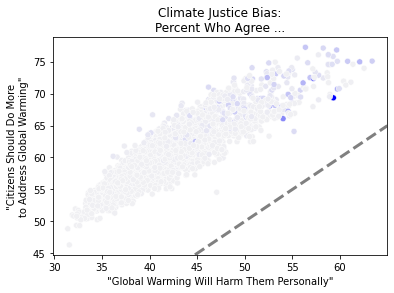

In [10]:
cmap = sns.color_palette("light:b", as_cmap=True)
chart = sns.scatterplot(data=opinions, 
                        x='personal', y='citizens',
                        hue='TotalPop', palette=cmap)
chart.axes.axline((50,50), slope=1, ls='--', linewidth=3, c='grey')
chart.set(title='Climate Justice Bias:\nPercent Who Agree ...',
        xlabel='"Global Warming Will Harm Them Personally"',
        ylabel='"Citizens Should Do More\nto Address Global Warming"')
chart.legend([], [], frameon=False)

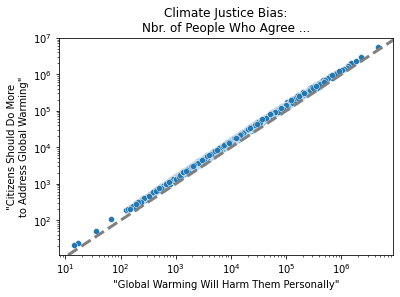

In [11]:
# Results hold when unit of analysis is a person
cmap = sns.color_palette("light:b", as_cmap=True)
chart = sns.scatterplot(data=weighted_opinions, x='personal', y='citizens', palette=cmap)
chart.set(xscale='log', yscale='log')
chart.axes.axline((50,50), (60,60), ls='--', linewidth=3, c='grey')
chart.set(title='Climate Justice Bias:\nNbr. of People Who Agree ...',
        xlabel='"Global Warming Will Harm Them Personally"',
        ylabel='"Citizens Should Do More\nto Address Global Warming"')
chart.legend([], [], frameon=False)

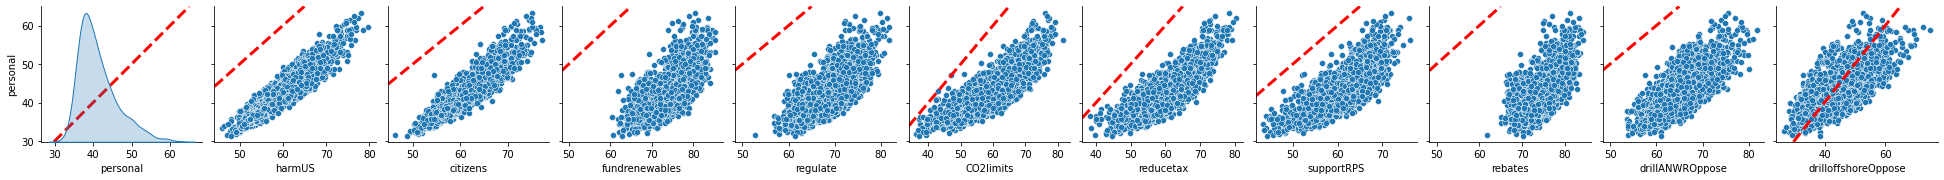

In [12]:
chart = sns.pairplot(data=opinions[['personal', 'harmUS', 'citizens'] + policies],
        y_vars='personal',kind='scatter', diag_kind='kde')
for ax in chart.axes.ravel():
    ax.axline((50,50), slope=1, ls='--', linewidth=3, c='red')

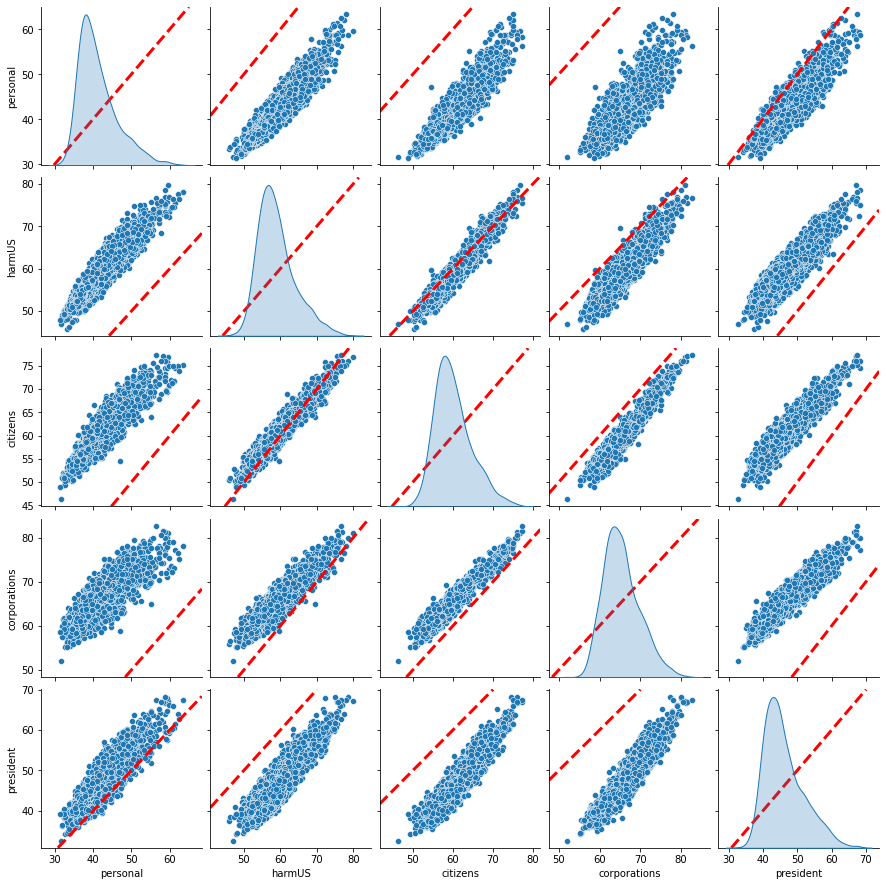

In [13]:
chart = sns.pairplot(data=opinions[['personal', 'harmUS', 'citizens', 'corporations', 'president']],
        kind='scatter', diag_kind='kde')
for ax in chart.axes.ravel():
    ax.axline((50,50), (60,60), ls='--', linewidth=3, c='red')

In [14]:
# Look for broadly popular or unpopular opinions, compared to other opinions
yy, xx, alphas = [], [], []
for qa in [q for q in questions if 'drill' not in q] + ['drillANWROppose','drilloffshoreOppose']:
    for qb in [q for q in questions if 'drill' not in q] + ['drillANWROppose','drilloffshoreOppose']:
        # We're swapping drill <-> drillOppose because those are the only ones with negative correlations
        if qa == qb:
            continue
        leveled_y = pd.Series(opinions.loc[:, qa] - opinions.loc[:, qb], name=qa)
        # Results are robust to counting people instead of percentages. (rebates and renewables still in top 7)
        # leveled_y = pd.Series(weighted_opinions.loc[:, qa] - weighted_opinions.loc[:, qb], name=qa)
        yy.append(qa)
        xx.append(qb)
        alphas.append(leveled_y.mean())

opinion_bias = pd.concat([pd.Series(yy,name='y'),
                            pd.Series(xx,name='x'),
                            pd.Series(alphas,name='alpha')], axis=1)
popular = opinion_bias.groupby('y').mean().assign(absalpha = lambda x: np.abs(x['alpha'])).sort_values('absalpha', ascending=False).head(7)
unpopular = opinion_bias.groupby('y').mean().assign(absalpha = lambda x: np.abs(x['alpha'])).sort_values('absalpha', ascending=False).tail(7)
pd.concat([popular, unpopular], axis=1)

,alpha,absalpha,alpha,absalpha
y,,,,
discuss,-25.858558,25.858558,NaN,NaN
mediaweekly,-25.826023,25.826023,NaN,NaN
rebates,18.722367,18.722367,NaN,NaN
fundrenewables,18.072428,18.072428,NaN,NaN
teachGW,17.093552,17.093552,NaN,NaN
exp,-16.591671,16.591671,NaN,NaN
personal,-15.008974,15.008974,NaN,NaN
reducetax,NaN,NaN,3.210258,3.210258
localofficials,NaN,NaN,-3.021264,3.021264


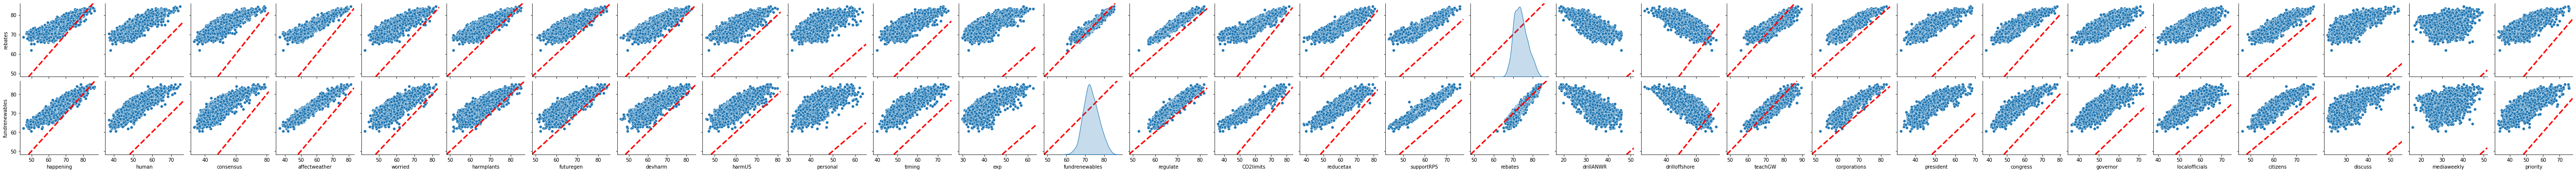

In [15]:
# Sanity check on the distributions
chart = sns.pairplot(data=opinions[questions], y_vars=['rebates','fundrenewables'],
        kind='scatter', diag_kind='kde')
for ax in chart.axes.ravel():
    ax.axline((50,50), slope=1, ls='--', linewidth=3, c='red')

In [16]:
# Test inter-question correlation
yy, xx, alphas, betas = [], [], [], []
for qa in [q for q in questions if 'drill' not in q] + ['drillANWROppose','drilloffshoreOppose']:
    for qb in [q for q in questions if 'drill' not in q] + ['drillANWROppose','drilloffshoreOppose']:
        if qa == qb:
            continue
        formula = "{} ~ {}".format(qa, qb)
        y, X = dmatrices(formula, data=opinions, return_type='dataframe')
        # Robust to counting people instead of percentages if you use elasticity:
        # formula = "np.log({}) ~ np.log({})".format(qa, qb)
        # y, X = dmatrices(formula, data=weighted_opinions, return_type='dataframe')
        mod = sm.OLS(y, X)
        res = mod.fit()
        yy.append(qa)
        xx.append(qb)
        alphas.append(res.params[0])
        betas.append(res.params[1])

opinion_pairs = pd.concat([pd.Series(yy,name='y'),
                            pd.Series(xx,name='x'),
                            pd.Series(alphas,name='alpha'),
                            pd.Series(betas,name='beta')], axis=1)
agreement = opinion_pairs.groupby('y').mean().assign(absbeta = lambda x: np.abs(x['beta'])).sort_values('absbeta', ascending=False).head(7)
disagreement = opinion_pairs.groupby('y').mean().assign(absbeta = lambda x: np.abs(x['beta'])).sort_values('absbeta', ascending=False).tail(7)
pd.concat([agreement, disagreement], axis=1)

,alpha,beta,absbeta,alpha,beta,absbeta
y,,,,,,
CO2limits,-11.016214,1.200007,1.200007,NaN,NaN,NaN
consensus,-16.067699,1.153281,1.153281,NaN,NaN,NaN
affectweather,-8.401482,1.138881,1.138881,NaN,NaN,NaN
priority,-15.572979,1.096969,1.096969,NaN,NaN,NaN
worried,-3.430093,1.073146,1.073146,NaN,NaN,NaN
drilloffshoreOppose,-15.301095,1.020534,1.020534,NaN,NaN,NaN
reducetax,0.334175,1.012410,1.012410,NaN,NaN,NaN
corporations,NaN,NaN,NaN,24.385968,0.721171,0.721171
discuss,NaN,NaN,NaN,-8.968363,0.692109,0.692109


## Data: Voting



This dataset are voting rates from the 2020 Presidential Election, as collates by NYT.

https://github.com/TheUpshot/presidential-precinct-map-2020

In [17]:
elections = gpd.read_file('precincts-with-results.geojson')

In [18]:
elections = elections.assign(
    CountyFIPS = elections['GEOID'].str.slice(0,5),
    StateFIPS = elections['GEOID'].str.slice(0,2).str.pad(5,'right','0'))

In [19]:
# Aggregate from the precinct level to the county level
e_by_c = elections.drop('geometry',axis=1) \
    .groupby(['StateFIPS','CountyFIPS']).sum() \
    .assign(dem_lead = lambda x: x['votes_dem'] - x['votes_rep'],
        pct_dem_lead = lambda x: 100 * x['dem_lead'] / x['votes_total'])
state_idx = e_by_c.index.get_level_values('StateFIPS')
county_idx = e_by_c.index.get_level_values('CountyFIPS')
county_elections = e_by_c.loc[state_idx != county_idx].reset_index()

In [20]:
def plot_resid(xs, resid_data):
    sns.pairplot(data=resid_data, x_vars=xs, y_vars='resid')

## Data: Urban

Data is from the Census urban and rural areas. It is for 2010 because the 2020 is not available yet.

https://www.census.gov/programs-surveys/geography/guidance/geo-areas/urban-rural/2010-urban-rural.html

In [21]:
urban = pd.read_excel('PctUrbanRural_County.xls')

In [22]:
urban = urban.assign(
    CountyFIPS = lambda x: (x['STATE']*1000 + x['COUNTY']).astype('str').str.pad(5, 'left','0'),
    StateFIPS = lambda x: x['CountyFIPS'].str.slice(0,2).str.pad(5, 'right','0'))

In [23]:
county_urban = urban.loc[urban['StateFIPS'] != urban['CountyFIPS']]

## Data: Industry Wage Dominance

From the Bureau of Economic Analysis

https://apps.bea.gov/regional/downloadzip.cfm

In [24]:
def stack(dataset):
    # Fix data format
    # Clean up encoding error in one file.
    with open(dataset + "/" + dataset + '_NM_2001_2020.csv', 'r', 
        encoding="latin-1", errors="surrogateescape") as f:
        data = f.read()
    with open(dataset + "/" + dataset + '_NM_2001_2020.csv.new', 'w', 
          encoding="utf-8-sig", errors="surrogateescape") as f:
        f.write(data)
    # Combine all state datas together
    state_data = []
    for f in os.listdir(dataset):
        if f == dataset + '_NM_2001_2020.csv':
            pass # bad version of NM file
        elif re.match(dataset + "_[A-Z]{2}_2001_2020.csv", f):
            # pattern will match cleaned NM file
            state_data.append(pd.read_csv(dataset + "/" + f, 
                            skipfooter=4, engine='python', 
                            on_bad_lines='skip'))
    return pd.concat(state_data, ignore_index=True)

In [25]:
wages = stack('CAINC5N')

In [26]:
# Subset just the money
wages = wages.loc[wages['Unit'] == 'Thousands of dollars']

In [27]:
def reshape_bea(val_name, data):
    # Clean and reshape data
    irrelevant = ['GeoName', 'Region', 'TableName', 
                'LineCode', 'Description', 'Unit']
    data = data.drop(irrelevant, axis=1) \
        .melt(id_vars=['GeoFIPS','IndustryClassification'],
            var_name='Year', value_name=val_name) \
        .assign(
            CountyFIPS = lambda x: x['GeoFIPS'].str.strip(' "'),
            StateFIPS = lambda x: x['CountyFIPS'].str.slice(0,2).str.pad(5, 'right','0'),
            NAICS = lambda x: x['IndustryClassification'].str.strip(' "'),
            Year = lambda x: x['Year'].str.strip(' "'))
    data[val_name] = data[val_name].str.strip(' "')
    return data

In [28]:
yearwages = reshape_bea('Money', wages)

In [29]:
def censor_bea(val_name, data):
    # Discard un-reported rows and convert dtype
    disclosed = data.loc[(data[val_name] != "(D)") & (data[val_name] != "(NA)")]
    disclosed = disclosed.astype({val_name:'float'})
    # Discard industry aggregates
    predicate = (disclosed['NAICS'] != '...') \
            & (~disclosed['NAICS'].str.contains('-')) \
            & (disclosed['NAICS'].str.len() == 2)
    # Discard non-county stuff
    predicate_ = (disclosed['CountyFIPS'] != disclosed['StateFIPS'])
    return disclosed.loc[predicate & predicate_]


In [30]:
completeyearwages = censor_bea('Money',yearwages)

In [31]:
def stats_bea(val_name, data):
    # Compute stats on jobs in each geo
    geo_sums = data.groupby(['StateFIPS','CountyFIPS']).sum().rename({'sum':val_name})
    geo_ind_sums = data.groupby(['StateFIPS','CountyFIPS','NAICS']).sum()
    geo_ind_pct = geo_ind_sums / geo_sums
    geo_sum = geo_sums[val_name].rename(val_name + '_sum')
    geo_std = geo_ind_pct.groupby(['StateFIPS','CountyFIPS'])[val_name].std().rename(val_name + '_std')
    geo_max = geo_ind_pct.groupby(['StateFIPS','CountyFIPS'])[val_name].max().rename(val_name + '_max')
    geo_max_ind_ = geo_ind_pct.groupby(['StateFIPS','CountyFIPS'])[val_name].idxmax()
    geo_max_ind = geo_ind_sums.loc[geo_max_ind_].reset_index('NAICS')['NAICS']
    # states = pd.Series(geo_sums.index.get_level_values('StateFIPS'), name='StateFIPS')
    # counties = pd.Series(geo_sums.index.get_level_values('CountyFIPS'), name='CountyFIPS')
    wide = pd.concat([geo_sum, geo_std, geo_max, geo_max_ind], axis=1)
    return wide.reset_index()

In [32]:
wage_dominance = stats_bea('Money', completeyearwages)

## Data: Industry Job Dominance

In [33]:
jobs = stack('CAEMP25N')

In [34]:
yearjobs = reshape_bea('Jobs', jobs)

In [35]:
completeyearjobs = censor_bea('Jobs',yearjobs)

In [36]:
job_dominance =  stats_bea('Jobs',completeyearjobs)

## Data: Cars

Data from Census ACS:

(I had to open in excel and remove the summary row from the top, then export to csv.)

https://www.census.gov/data/tables/time-series/demo/commuting/commuting-flows.html

In [37]:
carflow = pd.read_csv('table-2-county-to-county-commuting-flows-by-travel-mode-acs-2009-2013-noheader.csv',header=[0,1])

/Users/eric/miniconda3/envs/climate/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3251: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [38]:
# Fix Column types
header1 = carflow.columns.get_level_values(0).str.strip()
header2 = carflow.columns.get_level_values(1).str.strip()
carflow.columns = header1.str.cat(header2, sep='--')
carflow['Commuting Flow--Workers in Commuting Flow'] = pd.to_numeric(carflow['Commuting Flow--Workers in Commuting Flow'].str.replace(',',''))

In [39]:
# Compute percentage car drivers
bymode = carflow.groupby(['Residence--State FIPS Code', 'Residence--County FIPS Code', 'Commuting Flow--Travel Mode'])
byorigin = carflow.groupby(['Residence--State FIPS Code', 'Residence--County FIPS Code'])
num = bymode.sum()['Commuting Flow--Workers in Commuting Flow']
denom = byorigin.sum()['Commuting Flow--Workers in Commuting Flow']
pct_mode = num / denom
cars = pct_mode.loc[pct_mode.index.get_level_values('Commuting Flow--Travel Mode') == 'Car, truck, or van: Drove alone']

In [40]:
# Reformat to match other tables
cars = cars.reset_index().drop('Commuting Flow--Travel Mode', axis=1) \
    .rename(columns={'Residence--State FIPS Code':'StateFIPS', 
            'Residence--County FIPS Code':'CountyFIPS',
            'Commuting Flow--Workers in Commuting Flow':'pct_car'}) \
    .assign(
        CountyFIPS = lambda x: ((x['StateFIPS'].astype('int') * 1000) + x['CountyFIPS'].astype('int')).astype('str').str.pad(5, 'left', '0'),
        StateFIPS = lambda x: (x['StateFIPS'].astype('int') * 1000).astype('str').str.pad(5, 'left', '0')
    )

## Analysis: Regressions

In [41]:
def regression(y, xs, data, verbose=False, weights=None):
    formula = "{} ~ {}".format(y, " + ".join(xs))
    y, X = dmatrices(formula, data=data, return_type='dataframe')
    mod = sm.WLS(y, X, weights=weights) if weights is not None else sm.OLS(y, X)
    res = mod.fit()
    data = data.assign(resid = res.resid)
    print("R-Squared: {}".format(res.rsquared))
    print("F Stat: {} and F p-value: {}".format(res.fvalue, res.f_pvalue))
    if verbose:
        print(res.summary())
    return data

def twostage_regression(y, xs, fes, data, verbose=False):
    data = regression(y, fes, data, verbose=False)
    data = regression('resid', xs, data, verbose=True)
    return data

In [42]:
covariates = opinions.merge(county_elections, on=['StateFIPS','CountyFIPS'])
covariates = covariates.merge(county_urban,  on=['StateFIPS', 'CountyFIPS'])
covariates = covariates.merge(cars,  on=['StateFIPS', 'CountyFIPS'])
covariates = covariates.merge(wage_dominance,  on=['StateFIPS', 'CountyFIPS'])
covariates = covariates.merge(job_dominance,  on=['StateFIPS', 'CountyFIPS', 'NAICS'])

weighted_covariates = weighted_opinions.merge(county_elections, on=['StateFIPS','CountyFIPS'])
weighted_covariates = weighted_covariates.merge(county_urban,  on=['StateFIPS', 'CountyFIPS'])
weighted_covariates = weighted_covariates.merge(cars,  on=['StateFIPS', 'CountyFIPS'])
weighted_covariates = weighted_covariates.merge(wage_dominance,  on=['StateFIPS', 'CountyFIPS'])
weighted_covariates = weighted_covariates.merge(job_dominance,  on=['StateFIPS', 'CountyFIPS', 'NAICS'])

In [59]:
def minmax(series):
    return 100 * (series - np.min(series)) / (np.max(series) - np.min(series))

In [60]:
covariates = covariates.assign(
    logjobs = np.log(covariates['Jobs_sum']),
    logwage = np.log(covariates['Money_sum']),
    logvotes = np.log(covariates['votes_total']),
    Jobs_std = covariates['Jobs_std'] * 100,
    Jobs_max = covariates['Jobs_max'] * 100,
    Money_std = covariates['Money_std'] * 100,
    Money_max = covariates['Money_max'] * 100,
    pct_car = covariates['pct_car'] * 100
)
xs = ['logvotes', 'logjobs','Jobs_std','Jobs_max','logwage','Money_std','Money_max', 'pct_dem_lead', 'pct_car', 'POPPCT_URBAN']


In [63]:
weighted_covariates = weighted_covariates.assign(
    logpop = np.log(weighted_covariates['TotalPop']),
    logproblem = np.log(-1 * weighted_covariates['notmyproblem']), # because log < 0
    loghead =    np.log(-1 * weighted_covariates['notonmyhead']),
    logmarx =    np.log(weighted_covariates['marx']),
    logfaire =   np.log(weighted_covariates['laissezfaire']),
    logharm =   np.log(weighted_covariates['harmUS']),
    logpersonal =   np.log(weighted_covariates['personal']),
    logcitizens =   np.log(weighted_covariates['citizens']),
    logcorps =   np.log(weighted_covariates['corporations']),
    logprez =   np.log(weighted_covariates['president']),
    logvotesum = np.log(weighted_covariates['votes_total']),
    logjobsum =  np.log(weighted_covariates['Jobs_sum']),
    logwagesum = np.log(weighted_covariates['Money_sum']),
)

wlxs = ['logvotesum', 'logjobsum', 'Jobs_std', 'Jobs_max', 'logwagesum', 'Money_std', 'Money_max', 'pct_dem_lead', 'pct_car', 'POPPCT_URBAN']

### Findings

### Not My Problem

This is pretty hard to draw conclusions comparing the percent and people models.

In [64]:
reg_data = regression('notmyproblem', xs, data=covariates, verbose=True)

R-Squared: 0.19290206191119763
F Stat: 36.13785934088701 and F p-value: 8.449803293563293e-64
                            OLS Regression Results                            
Dep. Variable:           notmyproblem   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     36.14
Date:                Mon, 14 Mar 2022   Prob (F-statistic):           8.45e-64
Time:                        02:56:15   Log-Likelihood:                -3198.2
No. Observations:                1523   AIC:                             6418.
Df Residuals:                    1512   BIC:                             6477.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [46]:
wreg_data = regression('logproblem', wlxs, data=weighted_covariates, verbose=True, weights=weighted_covariates['logpop'])

R-Squared: 0.9914143750028442
F Stat: 17459.63206523564 and F p-value: 0.0
                            WLS Regression Results                            
Dep. Variable:             logproblem   R-squared:                       0.991
Model:                            WLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                 1.746e+04
Date:                Mon, 14 Mar 2022   Prob (F-statistic):               0.00
Time:                        02:43:18   Log-Likelihood:                 732.08
No. Observations:                1523   AIC:                            -1442.
Df Residuals:                    1512   BIC:                            -1384.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

### Personal

-.15% effect on car. the rest are basically 0

In [85]:
reg_data = regression('personal', xs, data=covariates, verbose=True)

R-Squared: 0.6775851978896397
F Stat: 317.7610992123287 and F p-value: 0.0
                            OLS Regression Results                            
Dep. Variable:               personal   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     317.8
Date:                Mon, 14 Mar 2022   Prob (F-statistic):               0.00
Time:                        03:54:54   Log-Likelihood:                -3737.7
No. Observations:                1523   AIC:                             7497.
Df Residuals:                    1512   BIC:                             7556.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

In [48]:
wreg_data = regression('logpersonal', wlxs, data=weighted_covariates, verbose=True, weights=weighted_covariates['logpop'])

R-Squared: 0.9857346306184208
F Stat: 10447.894629490933 and F p-value: 0.0
                            WLS Regression Results                            
Dep. Variable:            logpersonal   R-squared:                       0.986
Model:                            WLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                 1.045e+04
Date:                Mon, 14 Mar 2022   Prob (F-statistic):               0.00
Time:                        02:43:18   Log-Likelihood:                 327.99
No. Observations:                1523   AIC:                            -634.0
Df Residuals:                    1512   BIC:                            -575.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------

### Harm US

-.40% from job diversity vs +.09% from job dominance

also -.22% from cars

In [87]:
reg_data = regression('harmUS', xs, data=covariates, verbose=True)

R-Squared: 0.7771296835253019
F Stat: 527.2214353514653 and F p-value: 0.0
                            OLS Regression Results                            
Dep. Variable:                 harmUS   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     527.2
Date:                Mon, 14 Mar 2022   Prob (F-statistic):               0.00
Time:                        03:55:06   Log-Likelihood:                -3489.2
No. Observations:                1523   AIC:                             7000.
Df Residuals:                    1512   BIC:                             7059.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

### Corps

-.27% job diversity but +.19% from job money diversity

-.14% from cars

In [67]:
reg_data = regression('corporations', xs, data=covariates, verbose=True)

R-Squared: 0.8403715770342338
F Stat: 795.9997354282344 and F p-value: 0.0
                            OLS Regression Results                            
Dep. Variable:           corporations   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     796.0
Date:                Mon, 14 Mar 2022   Prob (F-statistic):               0.00
Time:                        03:00:19   Log-Likelihood:                -3041.8
No. Observations:                1523   AIC:                             6106.
Df Residuals:                    1512   BIC:                             6164.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

### Citizens

In [68]:
reg_data = regression('citizens', xs, data=covariates, verbose=True)

R-Squared: 0.8337999660132956
F Stat: 758.5471063820341 and F p-value: 0.0
                            OLS Regression Results                            
Dep. Variable:               citizens   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     758.5
Date:                Mon, 14 Mar 2022   Prob (F-statistic):               0.00
Time:                        03:01:32   Log-Likelihood:                -3104.4
No. Observations:                1523   AIC:                             6231.
Df Residuals:                    1512   BIC:                             6290.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

## Deprecated analysis: Covariates vs State Fixed Effects


### Single Stage on Xs

In [53]:
reg_data = regression('notmyproblem', xs, data=covariates, verbose=True) #, weights=wtd_log_covs['TotalPop'])

R-Squared: 0.19290206191119796
F Stat: 36.1378593408871 and F p-value: 8.44980329355969e-64
                            OLS Regression Results                            
Dep. Variable:           notmyproblem   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     36.14
Date:                Mon, 14 Mar 2022   Prob (F-statistic):           8.45e-64
Time:                        02:43:19   Log-Likelihood:                -3198.2
No. Observations:                1523   AIC:                             6418.
Df Residuals:                    1512   BIC:                             6477.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

In [54]:
reg_data = regression('logproblem', wlxs, data=weighted_covariates, verbose=True, weights=weighted_covariates['logpop'])

R-Squared: 0.9914143750028442
F Stat: 17459.63206523564 and F p-value: 0.0
                            WLS Regression Results                            
Dep. Variable:             logproblem   R-squared:                       0.991
Model:                            WLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                 1.746e+04
Date:                Mon, 14 Mar 2022   Prob (F-statistic):               0.00
Time:                        02:43:19   Log-Likelihood:                 732.08
No. Observations:                1523   AIC:                            -1442.
Df Residuals:                    1512   BIC:                            -1384.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

### Single Stage on State FE

In [55]:
reg_data = regression('personal', ['StateFIPS'], covariates, verbose=True)

TypeError: regression() got an unexpected keyword argument 'center'

### Singel Stage on both

In [ ]:
reg_data = regression('personal', xs + ['StateFIPS'], covariates, verbose=False)

### Two Stage State FE then Xs

In [82]:
reg_data = twostage_regression('personal', xs, ['StateFIPS'], covariates)

R-Squared: 0.28751574644820865
F Stat: 14.576644629366378 and F p-value: 6.196870758059085e-82
R-Squared: 0.53982661448606
F Stat: 177.37180523626722 and F p-value: 1.734749385437735e-246
                            OLS Regression Results                            
Dep. Variable:                  resid   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     177.4
Date:                Mon, 14 Mar 2022   Prob (F-statistic):          1.73e-246
Time:                        03:44:17   Log-Likelihood:                -3750.5
No. Observations:                1523   AIC:                             7523.
Df Residuals:                    1512   BIC:                             7582.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coe

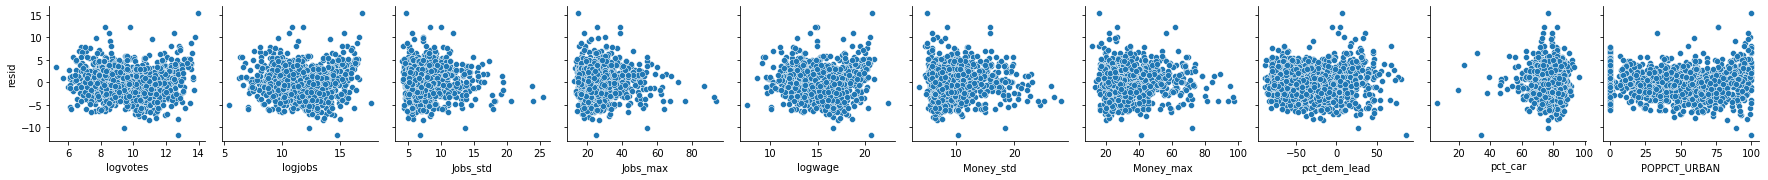

In [83]:
sns.pairplot(data=reg_data, x_vars=xs, y_vars='resid')